In [52]:
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

import pandas as pd
from pandas.api.types import CategoricalDtype

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import warnings

import json
import wandb

# k-meansの収束に関する警告を非表示にする
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
bubble_label = np.load("/home/cygnus/fujimoto/Cygnus-X_CAE/data/zroing_resize_data/resize_data/condition_match/bubble_region_label.npy")
np.sum(bubble_label == 0)

5380

In [3]:
api = wandb.Api()
artifact_path = 'yudai22-/condition_matching/training_log:v3'
artifact = api.artifact(artifact_path)

run = artifact.logged_by()


try:
    config_dict = json.loads(run.config)
    latent = config_dict["latent_num"]
    print(latent)
except json.JSONDecodeError:
    # run.config が有効なJSON文字列でなかった場合の処理
    print("エラー: run.config は有効なJSON形式ではありません。")
except TypeError:
    # run.config が文字列でなかった場合の処理 (念のため)
    print("エラー: run.config は文字列型ではありません。")


# latent = run.config["latent_num"]
print(latent)


match = re.findall('/.*/', artifact_path)
log_name = re.search(r"(training.*)", artifact_path).group()

print(log_name)
print(match[0][1:-1])

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: Currently logged in as: yudai22 (yudai22-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'value': 100}
{'value': 100}
training_log:v3
condition_matching


In [4]:
all_region_latent = np.load(f"/home/cygnus/fujimoto/Cygnus-X_CAE/analysis/check_latent/latent_list/{match[0][1:-1]}/all/{log_name}_all_latent.npy")
bubble_region_latent = np.load(f"/home/cygnus/fujimoto/Cygnus-X_CAE/analysis/check_latent/latent_list/{match[0][1:-1]}/bubble/{log_name}_bubble_latent.npy")
view_all_region = np.load("/home/cygnus/fujimoto/Cygnus-X_CAE/data/zroing_resize_data/resize_data/condition_match/vflip/CygnusX_cut_truncation_3size_resize_to_mode_percentile_100x100.npy")
bubble_region = np.load("/home/cygnus/fujimoto/Cygnus-X_CAE/data/zroing_resize_data/resize_data/condition_match/vflip/CygnusX_bubble_vflip.npy")

In [5]:
print(len(all_region_latent))

points = np.r_[all_region_latent, bubble_region_latent]
print(len(points))

7925
7956


In [6]:
# --- 2. k-means クラスタリングの実行 ---
# k-meansオブジェクトの初期化と学習
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, init='k-means++',random_state=0)
kmeans.fit(points)

# 各データポイントのクラスターラベルを取得
cluster_labels = kmeans.labels_
print(f"k-meansによるクラスターラベルの数: {len(np.unique(cluster_labels))}")

k-meansによるクラスターラベルの数: 3


In [7]:
bubble_label_list = list(bubble_label)
bubble_label_list += [0]*len(bubble_region)

In [8]:
khm_remove = []
for cluster, label in zip(cluster_labels, bubble_label_list):
    if label == 1:
        cluster = np.nan
    else:
        pass
    khm_remove.append(cluster)

# k-meansでつけられたラベルとnanが両方含まれた状態

In [9]:
kmh_array = np.array(khm_remove)
count = np.isnan(kmh_array)
print(len(kmh_array))
print(np.sum(count))

7956
2545


In [10]:
mask = ~np.isnan(kmh_array)
print(np.sum(mask))

# k-meansで得たラベルからbubbleと被っている領域を削除
kmh_mask = kmh_array[mask]
print(len(kmh_mask))
print(kmh_mask)

5411
5411
[2. 2. 1. ... 2. 0. 0.]


In [11]:
c_bubble = kmh_mask[-31:]
c_all = kmh_mask[:-31]
print(len(c_bubble))
print(len(c_all))

31
5380


In [12]:
all_num = len(c_all)

for unique_num in np.unique(kmh_mask):
    if np.isnan(unique_num):
        continue
    val_all = np.sum(c_all == unique_num)
    val_bubble = np.sum(c_bubble == unique_num)
    
    print(f"| cluster{int(unique_num)} | {'{:.1f}'.format(val_all/all_num*100)}% | {'{:.1f}'.format(val_bubble/len(c_bubble)*100)}% | {val_all}個 | {val_bubble}個 |")

| cluster0 | 22.5% | 32.3% | 1208個 | 10個 |
| cluster1 | 56.8% | 22.6% | 3056個 | 7個 |
| cluster2 | 20.7% | 45.2% | 1116個 | 14個 |


In [16]:
cleared_latent = []
for latent, label in zip(all_region_latent, bubble_label):
    if label == 0:
        cleared_latent.append(latent)
    else:
        pass

print(len(cleared_latent))

5380


In [17]:
all_plus_bubble_latent = np.concatenate((cleared_latent, bubble_region_latent))
print(len(all_plus_bubble_latent))

5411


In [18]:
tsne = TSNE(n_components=2, random_state=42)
digits_tsne = tsne.fit_transform(all_plus_bubble_latent)

In [20]:
cluster_labels = ["all"]*len(cleared_latent) + ["bubble"]*len(bubble_region_latent)

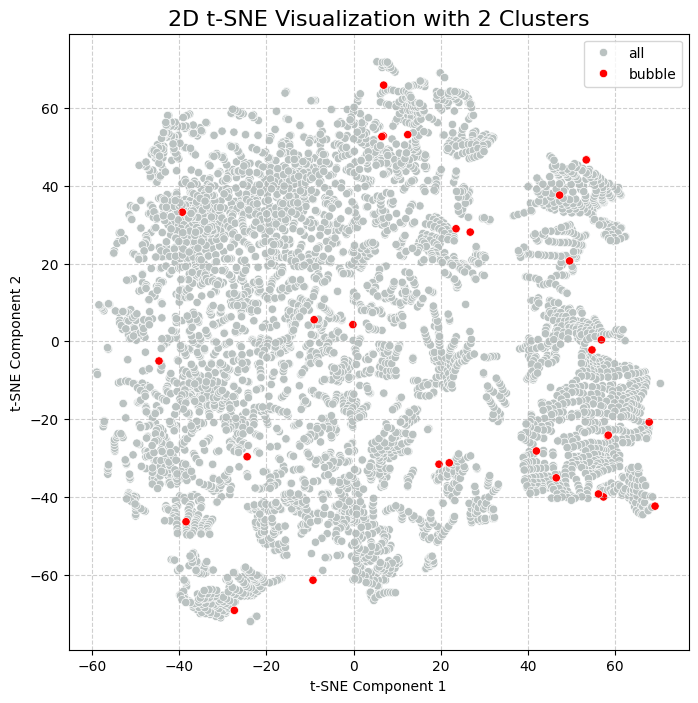

In [60]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=digits_tsne[:, 0], y=digits_tsne[:, 1], hue=cluster_labels, palette=["#bac2c1", "#ff0000"])
plt.title('2D t-SNE Visualization with 2 Clusters', fontsize=16)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("2D_t-SNE_Visualization_Remove_Bubble")
plt.show()

In [56]:
conversion_map = {
    0: "class 1",
    1: "class 2",
    2: "class 3"
}

converted_list = [conversion_map[num] for num in kmh_mask]

t-SNE後のデータ形状: (5411, 2)


/tmp/ipykernel_2444/814579987.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


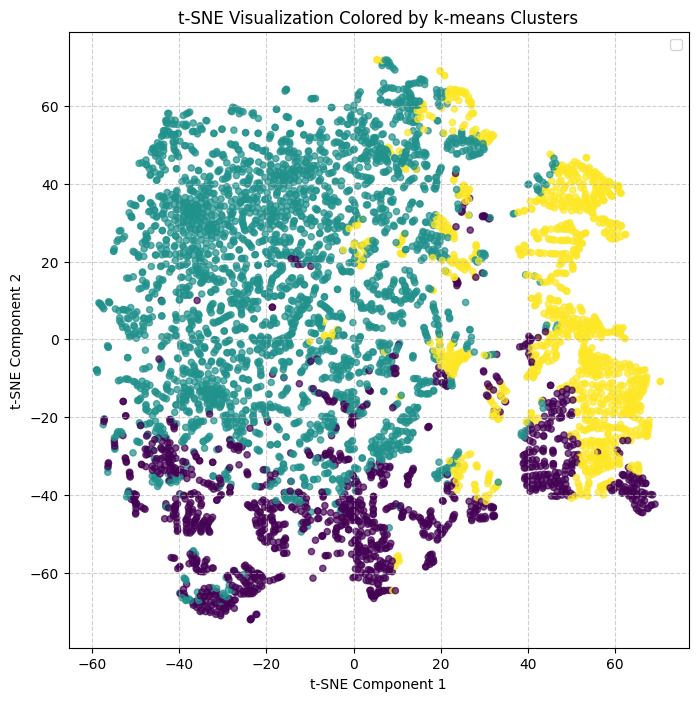

In [57]:
print(f"t-SNE後のデータ形状: {digits_tsne.shape}")

# --- 4. 可視化 (t-SNEの結果をk-meansのクラスターで色付け) ---
plt.figure(figsize=(8, 8))

# 散布図のプロット。c=cluster_labels でクラスターラベルに基づいて色を割り当てる
scatter = plt.scatter(digits_tsne[:, 0], digits_tsne[:, 1], 
                      c=kmh_mask, 
                      cmap='viridis', # カラーマップの指定
                      s=20, # ポイントのサイズ
                      alpha=0.7) # 透明度

# 凡例の追加
legend1 = plt.legend(*scatter.legend_elements(), 
                     title="Clusters", 
                     loc="lower left", 
                     bbox_to_anchor=(1.05, 0))
plt.gca().add_artist(legend1)
plt.legend()

plt.title('t-SNE Visualization Colored by k-means Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [58]:
desired_order = ["class 1", "class 2", "class 3"]

# PandasのCategoricalDtypeを作成し、順序とカテゴリを設定
category_type = CategoricalDtype(categories=desired_order, ordered=True)

# converted_list (リスト)をPandas Seriesに変換し、Categorical型に変換
cluster_labels_ordered = pd.Series(converted_list).astype(category_type)

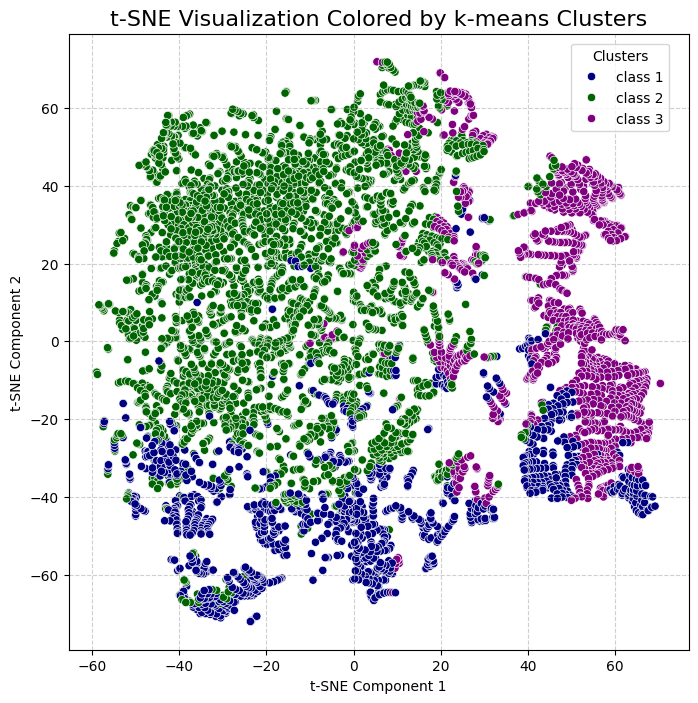

In [62]:
custom_palette = ["navy", "darkgreen", "purple"]

plt.figure(figsize=(8, 8)) 

sns.scatterplot(x=digits_tsne[:, 0], 
                y=digits_tsne[:, 1], 
                hue=cluster_labels_ordered, 
                palette=custom_palette,
                #s=50, # ポイントサイズを調整
                #alpha=0.7
               )

# 凡例の調整
plt.legend(title="Clusters", 
           loc="lower left", 
           bbox_to_anchor=(0.8, 0.83)
          )

# タイトルと軸ラベルの設定
plt.title('t-SNE Visualization Colored by k-means Clusters', fontsize=16)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
# sns.set_style("whitegrid") を使用しているため、plt.grid(True) は不要ですが、
# 互換性のため残すことも可能です。
plt.grid(linestyle='--', alpha=0.6)
plt.savefig("t-SNE_Visualization_Colored_by_k-means_Clusters")
plt.show()